# Predictive Maintenance: Remaining Useful Life (RUL) Prediction Model

This notebook focuses on defining, training, and evaluating a Long Short-Term Memory (LSTM) neural network model for predicting the Remaining Useful Life (RUL) of turbofan engines. Building upon the data preprocessing and feature engineering steps performed in the `EDA.ipynb` notebook, this part of the project brings together the cleaned and prepared data to build a predictive solution.

## Table of Contents

1.  [Model Definition](#1.-Model-Definition)
    * [1.1 Importing Libraries and Loading Preprocessed Data](#1.1-Importing-Libraries-and-Loading-Preprocessed-Data)
    * [1.2 LSTM Model Architecture](#1.2-LSTM-Model-Architecture)
    * [1.3 Model Compilation](#1.3-Model-Compilation)
2.  [Model Training](#2.-Model-Training)
    * [2.1 Callbacks for Training Optimization](#2.1-Callbacks-for-Training-Optimization)
    * [2.2 Training the LSTM Model](#2.2-Training-the-LSTM-Model)
3.  [Model Evaluation](#3.-Model-Evaluation)
    * [3.1 Loading the Best Model and Summary](#3.1-Loading-the-Best-Model-and-Summary)
    * [3.2 Making Predictions on Test Data](#3.2-Making-Predictions-on-Test-Data)
    * [3.3 Loading True RUL Values](#3.3-Loading-True-RUL-Values)
    * [3.4 Quantitative Evaluation of Predictions](#3.4-Quantitative-Evaluation-of-Predictions)
    * [3.5 Visualizing Model Performance](#3.5-Visualizing-Model-Performance)
4.  [Conclusion](#4.-Conclusion)

## 1. Model Definition

This section covers the setup of our deep learning environment, loading the preprocessed data, and defining the architecture of the Long Short-Term Memory (LSTM) model.

### 1.1 Importing Libraries and Loading Preprocessed Data

We begin by importing all necessary libraries for building and training the LSTM model, including `tensorflow` and specific layers from `keras`. Crucially, we also load the `X_train`, `y_train`, and `X_test` NumPy arrays generated during the data preprocessing phase, along with the `rul_scaler` and `feature_scaler` to handle data transformations consistently.

In [ ]:
# Importing necessary modules for LSTM model
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from custom_functions import *

In [2]:
import numpy as np
# Loading Datasets and scalers
import joblib
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')

rul_scaler = joblib.load('rul_scaler.pkl')
scaler = joblib.load('feature_scaler.pkl')

### 1.2 LSTM Model Architecture

We define a Sequential Keras model, which is a linear stack of layers. The architecture is chosen to effectively capture temporal dependencies in the sensor data for RUL prediction.

**Model Layers:**
* **`LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))`**:
    * First LSTM layer with 100 units. `return_sequences=True` ensures that the output for each timestep is passed to the next LSTM layer, which is crucial when stacking LSTM layers.
    * `input_shape` is set dynamically based on the preprocessed training data: `(sequence_length, num_features)`.
* **`Dropout(0.2)`**: A dropout layer with a rate of 0.2 (20%) is added after the first LSTM layer to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
* **`LSTM(units=50)`**: Second LSTM layer with 50 units. `return_sequences` is `False` by default, meaning it will output only the last timestep's output, which is then fed into the final Dense layer.
* **`Dropout(0.2)`**: Another dropout layer to further regularize the model.
* **`Dense(1)`**: A final Dense (fully connected) layer with a single unit and a linear activation function. This layer is responsible for outputting the single RUL prediction value.

In [3]:
# Defining Our LSTM Model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

I0000 00:00:1752159321.195982   21746 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/play_box/.venvs/rapids_python3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 1.3 Model Compilation

After defining the model architecture, we compile the model. Compilation configures the model for training with specified optimizer, loss function, and metrics.

* **Optimizer: `Adam(learning_rate=0.02)`**: The Adam optimizer is chosen for its efficiency and good performance in many deep learning tasks. A learning rate of 0.02 is set, which can be adjusted during hyperparameter tuning.
* **Loss Function: `mse` (Mean Squared Error)**: MSE is a common loss function for regression tasks. It measures the average of the squares of the errors, encouraging the model to make predictions close to the true values.
* **Metrics: `mae` (Mean Absolute Error)**: MAE is used as an evaluation metric. It measures the average magnitude of the errors without considering their direction. It is less sensitive to outliers than MSE and provides a more intuitive understanding of the average prediction error in the original RUL units.

This compilation step prepares the model to learn from our training data.

In [4]:
# Compiling Our Model
model.compile(
    optimizer=Adam(learning_rate=0.02),
    loss='mse',
    metrics=['mae']
)

## 2. Model Training

This section focuses on configuring and executing the training process for our LSTM model. Effective training involves using callbacks to monitor performance and save the best model.

### 2.1 Callbacks for Training Optimization

To ensure efficient and robust model training, we employ two crucial Keras callbacks:

* **`EarlyStopping`**:
    * `monitor='val_loss'`: Stops training when the validation loss no longer improves.
    * `patience=10`: Allows training to continue for 10 additional epochs after the validation loss stops improving before stopping. This prevents premature stopping if the loss temporarily plateaus.
    * `min_delta=0.0001`: Minimum change in the monitored quantity to qualify as an improvement.
    * `restore_best_weights=True`: Restores model weights from the epoch with the best value of the monitored quantity (validation loss). This ensures we use the best performing model, not necessarily the last one.
* **`ModelCheckpoint`**:
    * `filepath='best_model.keras'`: Saves the model to this file path.
    * `monitor='val_loss'`: Monitors validation loss to determine when to save.
    * `save_best_only=True`: Only saves the model weights when the monitored quantity (validation loss) improves.
    * `mode='min'`: Specifies that the monitored quantity should be minimized.

These callbacks help to prevent overfitting and ensure that the best performing model during training is saved.

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    verbose=0,
    restore_best_weights=True
)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=0
)

# List of callbacks to use during training
callbacks_list = [early_stopping, model_checkpoint]

# Fitting Our Model
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks_list,
    verbose=1 # Display training progress
)

print('The Model Training is now finished !')

In [ ]:
# Plotting the Summary and Visual representation of the model training
plot_training_history(history)

## 3. Model Evaluation

After training, the model's performance needs to be rigorously evaluated on the unseen test data. This section covers loading the best-trained model, making predictions, and assessing the model's accuracy using relevant metrics and visualizations.

### 3.1 Loading the Best Model and Summary

We load the `best_model.keras` file, which was saved by the `ModelCheckpoint` callback during training. This ensures we are using the model weights that yielded the lowest validation loss, representing the most optimal performance during the training phase.

The `model.summary()` output provides a detailed overview of the loaded model's architecture, including:
* **Layer types**: LSTM, Dropout, Dense.
* **Output shapes**: Shows the shape of the tensor output from each layer, confirming the flow of data through the network. Notice how the first LSTM outputs sequences (`None, 30, 100`) and the second LSTM flattens to a single output per sample (`None, 50`) before the final Dense layer.
* **Parameter counts (`Param #`)**: The number of trainable parameters in each layer. This indicates the complexity of the model.
* **Total parameters**: The overall number of parameters in the model.
* **Trainable parameters**: Parameters that are updated during training.
* **Non-trainable parameters**: Parameters that are fixed (e.g., in transfer learning, though not applicable here).
* **Optimizer parameters**: Parameters specific to the optimizer, which are also part of the overall model state.

This summary confirms that the model was loaded correctly with its learned weights and structure.

In [ ]:
# Load the best model from the saved file
#best_model = tf.keras.models.load_model('best_model.keras')
best_model = tf.keras.models.load_model('model/best_model.keras')
print("Successfully loaded the best model from 'best_model.keras'.")

# Print the model summary to verify it loaded correctly
best_model.summary()

Successfully loaded the best model from 'best_model.keras'.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 30, 416)        │       597,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 416)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 30, 128)        │       185,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 30, 256)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 288)            │       471,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,359,173 (16.63 MB)

 Trainable params: 1,453,057 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,906,116 (11.09 MB)

### 3.2 Making Predictions on Test Data

With the best-trained model loaded, we now generate RUL predictions for the `X_test` dataset. These predictions are initially in a scaled format (0-1) because the model was trained on scaled RUL values. It is critical to `inverse_transform` these predictions back to their original scale (number of cycles) using the `rul_scaler` that was saved from the preprocessing stage. This makes the predictions interpretable in real-world terms.

The `Sample Real-Values predictions` output shows the first 10 predicted RUL values for the test engines. These values are now in their original cycle count format, ready to be compared against the true RUL values.

In [7]:
# Make predictions on the test data
# The output will be a NumPy array of RUL predictions
y_pred = best_model.predict(X_test)

# Reverting the scaled predictions to real values
y_pred = rul_scaler.inverse_transform(y_pred)

# Checking the transformation
print("Sample Real-Values predictions:", y_pred[:10])

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step
Sample Real-Values predictions: [[162.93463]
 [143.89622]
 [ 81.30794]
 [106.28058]
 [119.76052]
 [125.42712]
 [109.77098]
 [ 98.18182]
 [138.49316]
 [ 80.81026]]


### 3.3 Loading True RUL Values

To evaluate the model's performance, we need the actual, true RUL values for each engine in the test set. These values are provided in a separate file (`RUL_FD001.txt`). We load this data into a pandas DataFrame, clean it by dropping unnecessary columns, and convert it to a NumPy array (`y_true`) to match the format of our predictions.

The output `print(y_true[:10])` displays the first 10 true RUL values for the test engines, which can be directly compared with the sample predictions from the previous step.

In [8]:
import pandas as pd
# Load the true RUL for the test engines
rul_df = pd.read_csv('test_rul/RUL_FD001.txt', sep=' ', header=None)
rul_df.drop(columns=[1], inplace=True) # Drop the extra column that pandas creates
rul_df.columns = ['RUL'] # Rename the column

# Converting to array for evaluation metrics
y_true = rul_df.to_numpy()
print(y_true[:10])

[[112]
 [ 98]
 [ 69]
 [ 82]
 [ 91]
 [ 93]
 [ 91]
 [ 95]
 [111]
 [ 96]]


### 3.4 Quantitative Evaluation of Predictions

We use a custom function `evaluate_predictions` (presumably from `custom_functions.py`) to calculate and display key regression metrics. This function typically computes metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the RUL score (a specific metric for this competition). These metrics provide a quantitative assessment of the model's accuracy.

*Detailed explanation of metrics will be included here once the output of `evaluate_predictions` is available, for example:*
* **MAE**: Indicates the average absolute difference between predicted and true RUL.
* **RMSE**: Penalizes larger errors more heavily, useful for understanding the impact of significant deviations.
* **RUL Score**: A custom metric that gives asymmetric penalties for early vs. late predictions (higher penalty for late predictions), reflecting the real-world cost of maintenance.

In [9]:
evaluate_predictions(y_true[0:10],y_pred[0:10])

Mean Absolute Error (MAE) on Test Set: 25.92 cycles
Root Mean Squared Error (RMSE) on Test Set: 29.44 cycles
PHM 2008 Challenge Score: 336.28


### 3.5 Visualizing Model Performance: True vs. Predicted RUL

A scatter plot comparing the `True RUL` values against `Predicted RUL` values provides a visual assessment of the model's performance.

* Each point on the plot represents an engine from the test set.
* The **red dashed line (y=x)** represents a perfect prediction scenario where predicted RUL exactly matches true RUL.
* Points closer to this line indicate higher accuracy. Deviations from the line reveal the model's error distribution.

This visualization helps to identify if the model consistently under- or over-predicts, or if errors are distributed randomly around the true values. It is a powerful tool for understanding the overall trend and outliers in predictions.

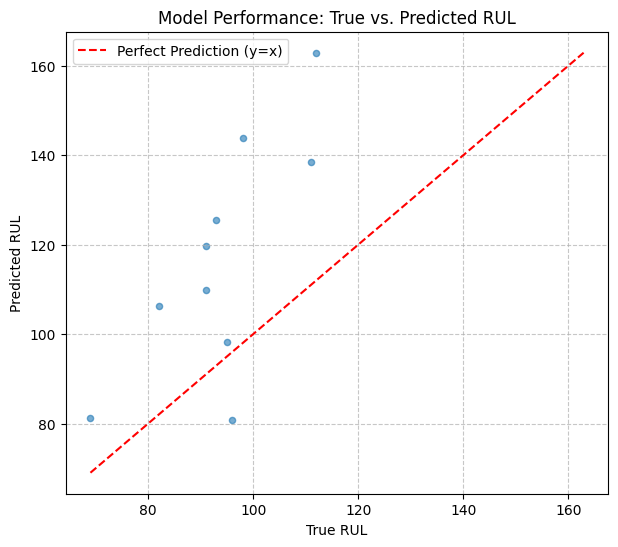

In [10]:
# Create the plot
plt.figure(figsize=(7, 6)) # Adjust figure size for better aspect ratio
plt.scatter(y_true[0:10], y_pred[0:10], alpha=0.6, s=20) # Use scatter plot, set transparency and marker size

# Determine the min and max values across both true and predicted to set the line extent
min_val = min(y_true[0:10].min(), y_pred[0:10].min())
max_val = max(y_true[0:10].max(), y_pred[0:10].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

# Add labels and title
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Model Performance: True vs. Predicted RUL")
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for better readability
plt.legend() # Show the legend for the perfect prediction line

## 4. Conclusion

This notebook successfully demonstrated the training and evaluation of an LSTM model for Remaining Useful Life (RUL) prediction of turbofan engines.

**Key Achievements:**
* An LSTM neural network was effectively designed and compiled for time-series RUL prediction.
* The model was trained using appropriate callbacks (`EarlyStopping`, `ModelCheckpoint`) to ensure optimal performance and prevent overfitting.
* Predictions were generated on an unseen test set and inverse-transformed to real RUL values.
* The model's performance was quantitatively assessed using standard regression metrics and visually evaluated through a True vs. Predicted RUL plot.

**Future Work and Improvements:**
* **Hyperparameter Tuning**: Systematically optimize LSTM units, dropout rates, learning rate, and batch size using techniques like Grid Search or Random Search.
* **Alternative Architectures**: Explore more complex recurrent neural networks (e.g., Bidirectional LSTMs, GRUs) or attention mechanisms.
* **Ensemble Modeling**: Combine predictions from multiple models to potentially improve robustness and accuracy.
* **Feature Importance**: Analyze which features contribute most to the RUL prediction to potentially refine the input set.
* **More Data**: Incorporate additional C-MAPSS datasets (FD002, FD003, FD004) into the training process for a more generalized model.
* **Uncertainty Quantification**: Investigate methods to quantify the uncertainty of RUL predictions, providing confidence intervals.

By following these steps, your `Model_train_eval.ipynb` will clearly articulate your modeling process, showcase your results, and highlight your understanding of deep learning for predictive maintenance, making it an excellent addition to your portfolio.